DXG

In [1]:
# 1. Import thư viện cần thiết
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN

In [2]:
def preprocess_stock_data(csv_file_path):
    # Load data from CSV file
    data = pd.read_csv(csv_file_path)
    data['Date'] = pd.to_datetime(data['Date'], format='%d/%m/%Y')
    data.set_index('Date', inplace=True)
    
    # Fill missing dates
    full_date_range = pd.date_range(start=data.index.min(), end=data.index.max(), freq='D')
    data = data.reindex(full_date_range)
    data = data.ffill()
    data.reset_index(inplace=True)
    data.rename(columns={'index': 'Date'}, inplace=True)
    
    # Convert volume from string to number
    def convert_volume_to_number(volume_str):
        if isinstance(volume_str, float) and np.isnan(volume_str):
            return np.nan
        if volume_str[-1] == 'K':
            return int(float(volume_str[:-1]) * 1000)
        elif volume_str[-1] == 'M':
            return int(float(volume_str[:-1]) * 1000000)
        elif volume_str[-1] == 'B':
            return int(float(volume_str[:-1]) * 1000000000)
        else:
            return int(volume_str)
    
    # Apply convert_volume_to_number function to Volume column
    data["Volume"] = data["Volume"].apply(convert_volume_to_number)
    
    # Convert change % from string to number
    def convert_change_to_number(change_str):
        if isinstance(change_str, float) and np.isnan(change_str):
            return np.nan
        new_change = float(change_str.strip('%')) / 100
        return new_change

    # Apply convert_change_to_number function to Change % column
    data["Change %"] = data["Change %"].apply(convert_change_to_number)
    
    # Function to convert string to number
    def convert_str_to_number(str_value):
        if isinstance(str_value, float) and np.isnan(str_value):
            return np.nan
        return float(str_value.replace(',', ''))
    
    # Apply convert_str_to_number function to Close, Open, High, Low columns
    data['Close'] = data['Close'].apply(convert_str_to_number)
    data['Open'] = data['Open'].apply(convert_str_to_number)
    data['High'] = data['High'].apply(convert_str_to_number)
    data['Low'] = data['Low'].apply(convert_str_to_number)
    
    data = data.sort_values('Date', ascending=True)
    return data

In [3]:
# 2. Đọc file csv và gắng index với giá Close
dxg = preprocess_stock_data('../../DATASET/DXG.csv')
dxg.set_index('Date',inplace=True)
dxg1 = dxg['Close']
dxg1

qcg = preprocess_stock_data('../../DATASET/QCG.csv')
qcg.set_index('Date',inplace=True)
qcg1 = qcg['Close']
qcg1

vhm = preprocess_stock_data('../../DATASET/VHM.csv')
vhm.set_index('Date',inplace=True)
vhm1 = vhm['Close']
vhm1

Date
2019-03-01    68421.0
2019-03-02    68421.0
2019-03-03    68421.0
2019-03-04    70075.0
2019-03-05    68421.0
               ...   
2024-05-27    39800.0
2024-05-28    39950.0
2024-05-29    39450.0
2024-05-30    39000.0
2024-05-31    38850.0
Name: Close, Length: 1919, dtype: float64

In [4]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))

dxg1=scaler.fit_transform(np.array(dxg1).reshape(-1,1))
qcg1=scaler.fit_transform(np.array(qcg1).reshape(-1,1))
vhm1=scaler.fit_transform(np.array(vhm1).reshape(-1,1))


In [5]:
# 4. Chia train test
#DXG
dxg_train_size = int(0.9 * len(dxg1))
dxg_test_size = len(dxg1) - dxg_train_size 
dxg_train_data = dxg1[:dxg_train_size]
dxg_test_data = dxg1[dxg_train_size:dxg_train_size+dxg_test_size]

qcg_train_size = int(0.9 * len(dxg1))
qcg_test_size = len(dxg1) - qcg_train_size 
qcg_train_data = dxg1[:qcg_train_size]
qcg_test_data = dxg1[qcg_train_size:qcg_train_size+qcg_test_size]

vhm_train_size = int(0.9 * len(vhm1))
vhm_test_size = len(vhm1) - vhm_train_size 
vhm_train_data = vhm1[:vhm_train_size]
vhm_test_data = vhm1[vhm_train_size:vhm_train_size+vhm_test_size]



In [6]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [7]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
#DXG
time_step = 100

dxg_X_train, dxg_y_train = create_dataset(dxg_train_data, time_step)
dxg_X_test, dxg_ytest = create_dataset(dxg_test_data, time_step)

qcg_X_train, qcg_y_train = create_dataset(qcg_train_data, time_step)
qcg_X_test, qcg_ytest = create_dataset(qcg_test_data, time_step)

vhm_X_train, vhm_y_train = create_dataset(vhm_train_data, time_step)
vhm_X_test, vhm_ytest = create_dataset(vhm_test_data, time_step)




In [8]:
# 7. Reshape input to be [samples, time steps, features] 

dxg_X_train =dxg_X_train.reshape(dxg_X_train.shape[0],dxg_X_train.shape[1] , 1)
dxg_X_test = dxg_X_test.reshape(dxg_X_test.shape[0],dxg_X_test.shape[1] , 1)

qcg_X_train =qcg_X_train.reshape(qcg_X_train.shape[0],qcg_X_train.shape[1] , 1)
qcg_X_test = qcg_X_test.reshape(qcg_X_test.shape[0],qcg_X_test.shape[1] , 1)

vhm_X_train =vhm_X_train.reshape(vhm_X_train.shape[0],vhm_X_train.shape[1] , 1)
vhm_X_test = vhm_X_test.reshape(vhm_X_test.shape[0],vhm_X_test.shape[1] , 1)



In [9]:
# 8. Define GRU Model

dxg_model = Sequential()
dxg_model.add(SimpleRNN(50, input_shape=(time_step, 1)))
dxg_model.add(Dense(1))
dxg_model.compile(optimizer='adam', loss='mean_squared_error')

qcg_model = Sequential()
qcg_model.add(SimpleRNN(50, input_shape=(time_step, 1)))
qcg_model.add(Dense(1))
qcg_model.compile(optimizer='adam', loss='mean_squared_error')

vhm_model = Sequential()
vhm_model.add(SimpleRNN(50, input_shape=(time_step, 1)))
vhm_model.add(Dense(1))
vhm_model.compile(optimizer='adam', loss='mean_squared_error')



c:\Users\Khang\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [10]:
# 9. Fit mô hình với dữ liệu train
dxg_model.fit(dxg_X_train,dxg_y_train,validation_data=(dxg_X_test,dxg_ytest),epochs=100,batch_size=64,verbose=1)
qcg_model.fit(qcg_X_train,qcg_y_train,validation_data=(qcg_X_test,qcg_ytest),epochs=100,batch_size=64,verbose=1)
vhm_model.fit(vhm_X_train,vhm_y_train,validation_data=(vhm_X_test,vhm_ytest),epochs=100,batch_size=64,verbose=1)


Epoch 1/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step - loss: 0.0463 - val_loss: 9.7118e-04
Epoch 2/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 9.5479e-04 - val_loss: 3.3300e-04
Epoch 3/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 6.4474e-04 - val_loss: 3.3016e-04
Epoch 4/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.8171e-04 - val_loss: 2.3665e-04
Epoch 5/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 5.4946e-04 - val_loss: 2.0408e-04
Epoch 6/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.8123e-04 - val_loss: 2.1111e-04
Epoch 7/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 4.5825e-04 - val_loss: 2.2447e-04
Epoch 8/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.1538e-04 - val_loss: 2.1937e-04
Epoch 9/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.3367e-04 - val_loss: 3.3401e-04
Epoch 10/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.5172e-04 - val_loss: 1.5225e-04
Epoch 11/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 4.

In [11]:
# 10. Dự báo dữ liệu test, val
dxg_train_predict=dxg_model.predict(dxg_X_train)
dxg_y_pred=dxg_model.predict(dxg_X_test)

qcg_train_predict=qcg_model.predict(qcg_X_train)
qcg_y_pred=qcg_model.predict(qcg_X_test)

vhm_train_predict=vhm_model.predict(vhm_X_train)
vhm_y_pred=vhm_model.predict(vhm_X_test)


51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


In [12]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
dxg_train_predict=scaler.inverse_transform(dxg_train_predict)
dxg_y_pred=scaler.inverse_transform(dxg_y_pred)

qcg_train_predict=scaler.inverse_transform(qcg_train_predict)
qcg_y_pred=scaler.inverse_transform(qcg_y_pred)


vhm_train_predict=scaler.inverse_transform(vhm_train_predict)
vhm_y_pred=scaler.inverse_transform(vhm_y_pred)


In [13]:
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_absolute_error

#DXG
actual=scaler.inverse_transform(dxg_test_data)
actual= actual[101:]
forecast = dxg_y_pred 
rmse = np.sqrt(np.mean((forecast - actual)**2))
mape = np.mean(np.abs((actual - forecast) / actual))
mae = mean_absolute_error(actual, forecast)

print('DXG')
print('RMSE:', rmse)
print('MAPE: ', mape)
print(f"Mae: {mae}\n")

#QCG
actual=scaler.inverse_transform(qcg_test_data)
actual= actual[101:]
forecast = qcg_y_pred 
rmse = np.sqrt(np.mean((forecast - actual)**2))
mape = np.mean(np.abs((actual - forecast) / actual))
mae = mean_absolute_error(actual, forecast)
print('QCG')
print('RMSE:', rmse)
print('MAPE: ', mape)
print(f"Mae: {mae}\n")


# VHM
actual=scaler.inverse_transform(vhm_test_data)
actual= actual[101:]
forecast = vhm_y_pred 
rmse = np.sqrt(np.mean((forecast - actual)**2))
mape = np.mean(np.abs((actual - forecast) / actual))
mae = mean_absolute_error(actual, forecast)

print('VHM')
print('RMSE:', rmse)
print('MAPE: ', mape)
print(f"Mae: {mae}\n")

DXG
RMSE: 663.951776432022
MAPE:  0.008861838820728826
Mae: 464.2278126937491

QCG
RMSE: 698.8370952600984
MAPE:  0.010043786120035687
Mae: 525.4115929847135

VHM
RMSE: 538.7851826769753
MAPE:  0.00868920787435013
Mae: 362.5328382554945



In [14]:
# 13. Dự báo 30 ngày tiếp theo
x_input=dxg_test_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

dxg_lst_output=[]
n_steps=len(temp_input) - 1
i=0
while(i<90):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = dxg_model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        dxg_lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = dxg_model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        dxg_lst_output.extend(yhat.tolist())
        i=i+1


0 day input [0.31143763 0.306439   0.30393968 0.30144036 0.30518934 0.30518934
 0.30518934 0.3001907  0.3001907  0.2939424  0.29644172 0.29519206
 0.29519206 0.29519206 0.29269274 0.29269274 0.29144308 0.29144308
 0.29144308 0.29144308 0.29144308 0.29144308 0.29144308 0.29144308
 0.29894104 0.30518934 0.30518934 0.30518934 0.30144036 0.30518934
 0.3001907  0.2939424  0.28269547 0.28269547 0.28269547 0.27769683
 0.28644444 0.28269547 0.2876941  0.29269274 0.29269274 0.29269274
 0.29769138 0.29519206 0.28519478 0.29019342 0.28269547 0.28269547
 0.28269547 0.27519751 0.26894921 0.28519478 0.28394512 0.28894376
 0.28894376 0.28894376 0.306439   0.2939424  0.3001907  0.31893559
 0.32768321 0.32768321 0.32768321 0.32393423 0.32768321 0.33893014
 0.33143218 0.32768321 0.32768321 0.32768321 0.33643082 0.35142674
 0.33143218 0.33268184 0.32893287 0.32893287 0.32893287 0.32518389
 0.33518116 0.32143491 0.31268729 0.32643355 0.32643355 0.32643355
 0.29269274 0.27269819 0.24895466 0.24895466 0.221

In [15]:
len(
temp_input)

132

In [16]:
# 13. Dự báo 30 ngày tiếp theo
x_input=qcg_test_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

qcg_lst_output=[]
n_steps=len(temp_input) - 1
i=0
while(i<90):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = qcg_model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        qcg_lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = qcg_model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        qcg_lst_output.extend(yhat.tolist())
        i=i+1


0 day input [0.31143763 0.306439   0.30393968 0.30144036 0.30518934 0.30518934
 0.30518934 0.3001907  0.3001907  0.2939424  0.29644172 0.29519206
 0.29519206 0.29519206 0.29269274 0.29269274 0.29144308 0.29144308
 0.29144308 0.29144308 0.29144308 0.29144308 0.29144308 0.29144308
 0.29894104 0.30518934 0.30518934 0.30518934 0.30144036 0.30518934
 0.3001907  0.2939424  0.28269547 0.28269547 0.28269547 0.27769683
 0.28644444 0.28269547 0.2876941  0.29269274 0.29269274 0.29269274
 0.29769138 0.29519206 0.28519478 0.29019342 0.28269547 0.28269547
 0.28269547 0.27519751 0.26894921 0.28519478 0.28394512 0.28894376
 0.28894376 0.28894376 0.306439   0.2939424  0.3001907  0.31893559
 0.32768321 0.32768321 0.32768321 0.32393423 0.32768321 0.33893014
 0.33143218 0.32768321 0.32768321 0.32768321 0.33643082 0.35142674
 0.33143218 0.33268184 0.32893287 0.32893287 0.32893287 0.32518389
 0.33518116 0.32143491 0.31268729 0.32643355 0.32643355 0.32643355
 0.29269274 0.27269819 0.24895466 0.24895466 0.221

0 day output [[0.24868637]]
1 day input [0.306439   0.30393968 0.30144036 0.30518934 0.30518934 0.30518934
 0.3001907  0.3001907  0.2939424  0.29644172 0.29519206 0.29519206
 0.29519206 0.29269274 0.29269274 0.29144308 0.29144308 0.29144308
 0.29144308 0.29144308 0.29144308 0.29144308 0.29144308 0.29894104
 0.30518934 0.30518934 0.30518934 0.30144036 0.30518934 0.3001907
 0.2939424  0.28269547 0.28269547 0.28269547 0.27769683 0.28644444
 0.28269547 0.2876941  0.29269274 0.29269274 0.29269274 0.29769138
 0.29519206 0.28519478 0.29019342 0.28269547 0.28269547 0.28269547
 0.27519751 0.26894921 0.28519478 0.28394512 0.28894376 0.28894376
 0.28894376 0.306439   0.2939424  0.3001907  0.31893559 0.32768321
 0.32768321 0.32768321 0.32393423 0.32768321 0.33893014 0.33143218
 0.32768321 0.32768321 0.32768321 0.33643082 0.35142674 0.33143218
 0.33268184 0.32893287 0.32893287 0.32893287 0.32518389 0.33518116
 0.32143491 0.31268729 0.32643355 0.32643355 0.32643355 0.29269274
 0.27269819 0.24895466 

In [17]:
# 13. Dự báo 30 ngày tiếp theo
x_input=vhm_test_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

vhm_lst_output=[]
n_steps=len(temp_input) - 1
i=0
while(i<90):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = vhm_model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        vhm_lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = vhm_model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        vhm_lst_output.extend(yhat.tolist())
        i=i+1


0 day input [0.09050764 0.07757798 0.08056174 0.07260503 0.07061585 0.07061585
 0.07061585 0.06663749 0.07061585 0.06066996 0.05470242 0.05470242
 0.05470242 0.05470242 0.05569701 0.05072406 0.06663749 0.06663749
 0.06663749 0.06663749 0.06663749 0.06663749 0.06663749 0.06663749
 0.06962126 0.0845401  0.0845401  0.0845401  0.1412317  0.15316677
 0.13029122 0.12631286 0.09647518 0.09647518 0.09647518 0.09746976
 0.11437778 0.11835614 0.09846435 0.10940484 0.10940484 0.10940484
 0.10940484 0.1034373  0.09249682 0.094486   0.08155633 0.08155633
 0.08155633 0.08155633 0.0845401  0.08951305 0.08851846 0.07857257
 0.07857257 0.07857257 0.07260503 0.08851846 0.08056174 0.08851846
 0.08652928 0.08652928 0.08652928 0.08155633 0.08553469 0.08056174
 0.09647518 0.08752387 0.08752387 0.08752387 0.08851846 0.09349141
 0.09249682 0.09050764 0.08951305 0.08951305 0.08951305 0.09050764
 0.094486   0.11437778 0.1133832  0.12034532 0.12034532 0.12034532
 0.07857257 0.0845401  0.06663749 0.06663749 0.060

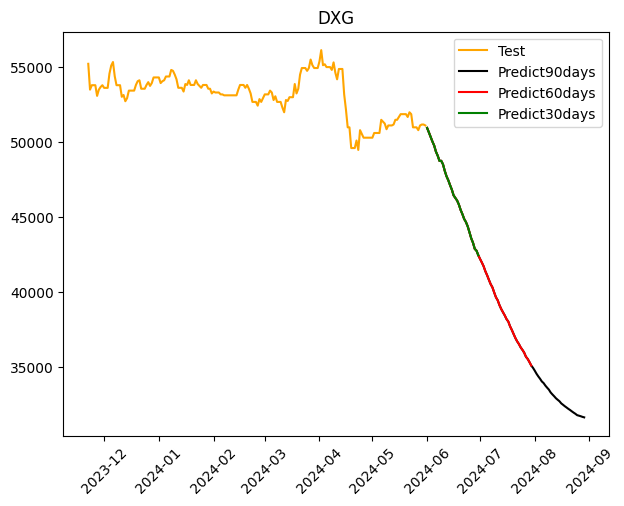

In [22]:
# 14.Vẽ hình
# fig, axs = plt.subplots(1, 3, figsize=(15, 5))
# new = pd.date_range(start=dxg.index[0], end=dxg.index[dxg_train_size-1])
# plt.plot(new,scaler.inverse_transform(dxg_train_data))

new = pd.date_range(start=dxg.index[dxg_train_size], end=dxg.index[-1])
plt.plot(new,scaler.inverse_transform(dxg_test_data),color='orange')

start_date = dxg.index[-1] + datetime.timedelta(1)
dxg_predict_data_30 = pd.date_range(start=start_date, end=start_date + datetime.timedelta(29))
dxg_predict_data_60 = pd.date_range(start=start_date, end=start_date + datetime.timedelta(59))
dxg_predict_data_90 = pd.date_range(start=start_date, end=start_date + datetime.timedelta(89))
plt.plot(dxg_predict_data_90,scaler.inverse_transform(dxg_lst_output[:90]),color='black')
plt.plot(dxg_predict_data_60,scaler.inverse_transform(dxg_lst_output[:60]), color='red')
plt.plot(dxg_predict_data_30,scaler.inverse_transform(dxg_lst_output[:30]),color='green')
plt.legend(['Test','Predict90days','Predict60days','Predict30days'])
plt.title('DXG')
plt.tight_layout()
plt.xticks(rotation=45)

plt.show()

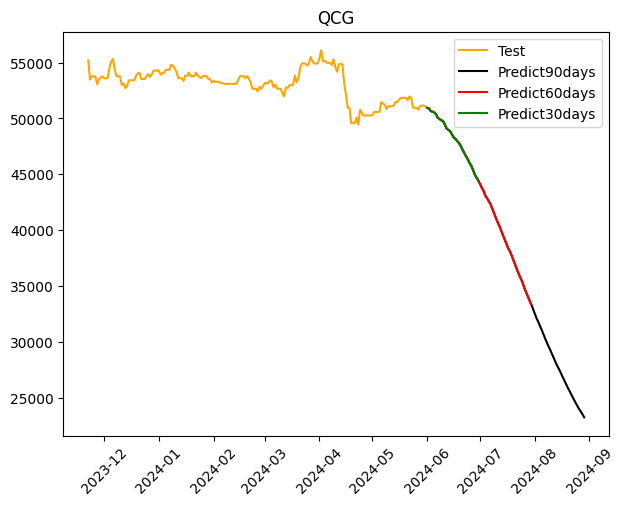

In [23]:
new = pd.date_range(start=qcg.index[qcg_train_size], end=qcg.index[-1])
plt.plot(new,scaler.inverse_transform(qcg_test_data),color='orange')

start_date = qcg.index[-1] + datetime.timedelta(1)
qcg_predict_data_30 = pd.date_range(start=start_date, end=start_date + datetime.timedelta(29))
qcg_predict_data_60 = pd.date_range(start=start_date, end=start_date + datetime.timedelta(59))
qcg_predict_data_90 = pd.date_range(start=start_date, end=start_date + datetime.timedelta(89))
plt.plot(qcg_predict_data_90,scaler.inverse_transform(qcg_lst_output[:90]),color='black')
plt.plot(qcg_predict_data_60,scaler.inverse_transform(qcg_lst_output[:60]), color='red')
plt.plot(qcg_predict_data_30,scaler.inverse_transform(qcg_lst_output[:30]),color='green')
plt.legend(['Test','Predict90days','Predict60days','Predict30days'])
plt.title('QCG')
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

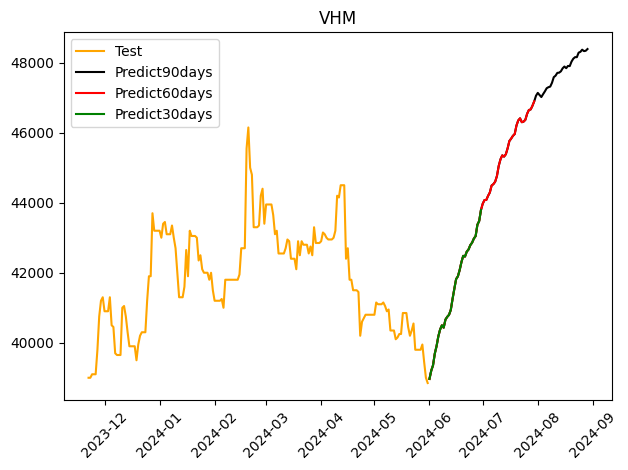

In [21]:
new = pd.date_range(start=vhm.index[vhm_train_size], end=vhm.index[-1])
plt.plot(new,scaler.inverse_transform(vhm_test_data),color='orange')

start_date = vhm.index[-1] + datetime.timedelta(1)
vhm_predict_data_30 = pd.date_range(start=start_date, end=start_date + datetime.timedelta(29))
vhm_predict_data_60 = pd.date_range(start=start_date, end=start_date + datetime.timedelta(59))
vhm_predict_data_90 = pd.date_range(start=start_date, end=start_date + datetime.timedelta(89))
plt.plot(vhm_predict_data_90,scaler.inverse_transform(vhm_lst_output[:90]),color='black')
plt.plot(vhm_predict_data_60,scaler.inverse_transform(vhm_lst_output[:60]), color='red')
plt.plot(vhm_predict_data_30,scaler.inverse_transform(vhm_lst_output[:30]),color='green')
plt.legend(['Test','Predict90days','Predict60days','Predict30days'])
plt.title('VHM')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()